# Random forest model to predict price of bulldozers

This is a part of the fast.ai course where we are using a simple random forest algorightm to solve the kaggle challenge -
[Blue book for bulldozers](https://www.kaggle.com/c/bluebook-for-bulldozers)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

%matplotlib inline
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)

In [2]:
raw_data = pd.read_csv('bulldozers_train_data.csv', low_memory=False, parse_dates=['saledate'])

In [3]:
raw_data.head(5)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## DATA EXPLORATION

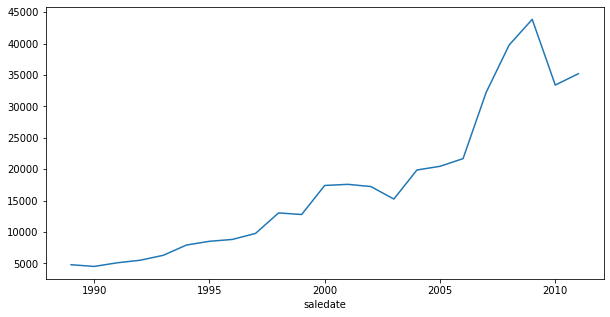

In [4]:
## plot sales per year
fig, ax = plt.subplots(figsize=(10,5))
raw_data.groupby(raw_data['saledate'].dt.year)['SalePrice'].count().plot(ax=ax)

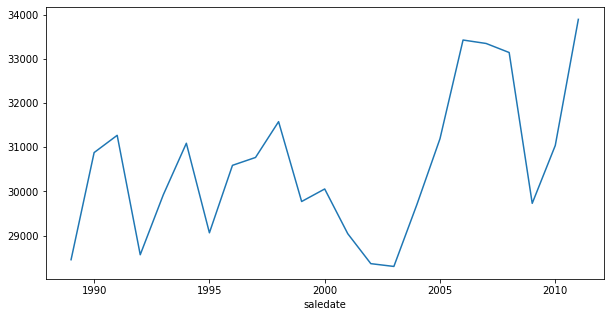

In [5]:
## plot sales number per year
fig, ax = plt.subplots(figsize=(10,5))
raw_data.groupby(raw_data['saledate'].dt.year)['SalePrice'].mean().plot(ax=ax)

In [6]:
## shape
raw_data.shape

(401125, 53)

## FEATURE ENGINEERING (for entire dataset)

In [7]:
# transform the sale price to log data
raw_data['SalePrice'] = np.log(raw_data['SalePrice'])

In [8]:
# feature engineering for the dates
def add_datepart(df, fldname):
    fld = df[fldname]
    target_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end'
             , 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        
        df[target_pre+n] = getattr(fld.dt, n.lower())
    df[target_pre+'Elapsed'] = (fld - fld.min()).dt.days
    df.drop(fldname, axis=1, inplace=True)
    return df

raw_data = add_datepart(raw_data, 'saledate')

In [9]:
# convert usage band to ordinal type
raw_data['UsageBand'].astype('category').cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [10]:
# convert non numeric values to categories
def numericalize(df, col, name):
    if not pd.api.types.is_numeric_dtype(col):
        col = col.astype('category')
        df[name] = col.cat.codes+1
        
for n, c in raw_data.items():
    if n == 'SalePrice':
        continue
    print(f"processing column {n}")
    numericalize(raw_data, c, n)

processing column SalesID
processing column MachineID
processing column ModelID
processing column datasource
processing column auctioneerID
processing column YearMade
processing column MachineHoursCurrentMeter
processing column UsageBand
processing column fiModelDesc
processing column fiBaseModel
processing column fiSecondaryDesc
processing column fiModelSeries
processing column fiModelDescriptor
processing column ProductSize
processing column fiProductClassDesc
processing column state
processing column ProductGroup
processing column ProductGroupDesc
processing column Drive_System
processing column Enclosure
processing column Forks
processing column Pad_Type
processing column Ride_Control
processing column Stick
processing column Transmission
processing column Turbocharged
processing column Blade_Extension
processing column Blade_Width
processing column Enclosure_Type
processing column Engine_Horsepower
processing column Hydraulics
processing column Pushblock
processing column Ripper
p

In [11]:
# fill missing variables
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(raw_data)
raw_data_columns = raw_data.columns
df = imp.transform(raw_data)
cleaned_data = pd.DataFrame(df, columns=raw_data_columns)
cleaned_data = cleaned_data.reset_index(drop=True)

### split into train test dataset

In [12]:
## split data into training and validation set
## we want to keep the latest data for the test set hence we 
## sort the values before splitting the dataset manually
cleaned_data.sort_values(by=['saleYear', 'saleMonth', 'saleDay'], inplace=True, ascending=True)

test_set_len = round(cleaned_data.shape[0]*0.05)
train_set_len = cleaned_data.shape[0] - test_set_len

def split_data(df, lenth_of_split):
    return df[:lenth_of_split], df[lenth_of_split:]

train_df, test_df = split_data(cleaned_data, train_set_len)

In [13]:
# get X_train, y_train, X_test, y_test
y_train = train_df['SalePrice'].values
X_train = train_df.drop(['SalePrice'], axis=1)

y_test = test_df['SalePrice'].values
X_test = test_df.drop(['SalePrice'], axis=1)

In [14]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(381069, 64) (381069,) (20056, 64) (20056,)


### modelling

In [15]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=30, max_features=0.5)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [16]:
# score the test set data
m.score(X_test, y_test)

0.884436507935598

In [17]:
# get the RMLSE
mean_squared_error(y_test, m.predict(X_test), squared=False)

0.24306968112451657

## RF exploration

In [18]:
# explore the prediction of each tree and find the mean
preds = np.stack([t.predict(X_test) for t in m.estimators_])
print(np.mean(preds[:, 0]))
print(y_test[0])

9.651708551318855
9.852194258148577


In [19]:
m.predict(X_test)[0]

9.651708551318855

In [20]:
preds.shape

(30, 20056)

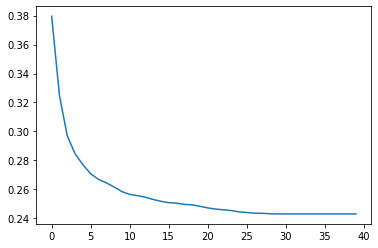

In [21]:
plt.plot([mean_squared_error(y_test, np.mean(preds[:i+1], axis=0), squared=False) for i in range(40)])

#### Feature Importances

In [22]:
## get feature importances
importances = m.feature_importances_
importances

array([3.07235491e-02, 1.93821500e-02, 5.44319564e-02, 1.17952059e-03,
       4.54601437e-03, 1.68487186e-01, 2.55558924e-03, 9.70403613e-04,
       3.43994506e-02, 2.38374000e-02, 4.54406361e-02, 4.71613648e-03,
       3.23015765e-02, 9.18745930e-02, 7.47795927e-02, 7.71264085e-03,
       1.05280590e-02, 1.55395584e-02, 1.18584895e-02, 3.15518527e-02,
       7.83277167e-04, 1.74458787e-03, 9.74241757e-04, 1.40565961e-03,
       1.39567461e-03, 3.90666394e-04, 9.34220244e-04, 4.78346977e-04,
       1.00738124e-03, 1.22897322e-04, 3.49478268e-03, 5.62570335e-04,
       2.56644064e-03, 2.00143761e-03, 1.46792803e-03, 6.18681746e-03,
       1.35132868e-03, 9.00973009e-02, 2.68582471e-02, 7.11554795e-02,
       4.77725386e-03, 7.87157291e-04, 2.72140578e-03, 7.45890641e-04,
       1.08744877e-03, 4.30971918e-04, 3.52456007e-04, 2.11184502e-03,
       1.42053250e-03, 2.16262892e-04, 2.28194186e-04, 2.09653930e-02,
       2.88726930e-03, 5.53695507e-03, 7.43148533e-03, 4.05921096e-03,
      

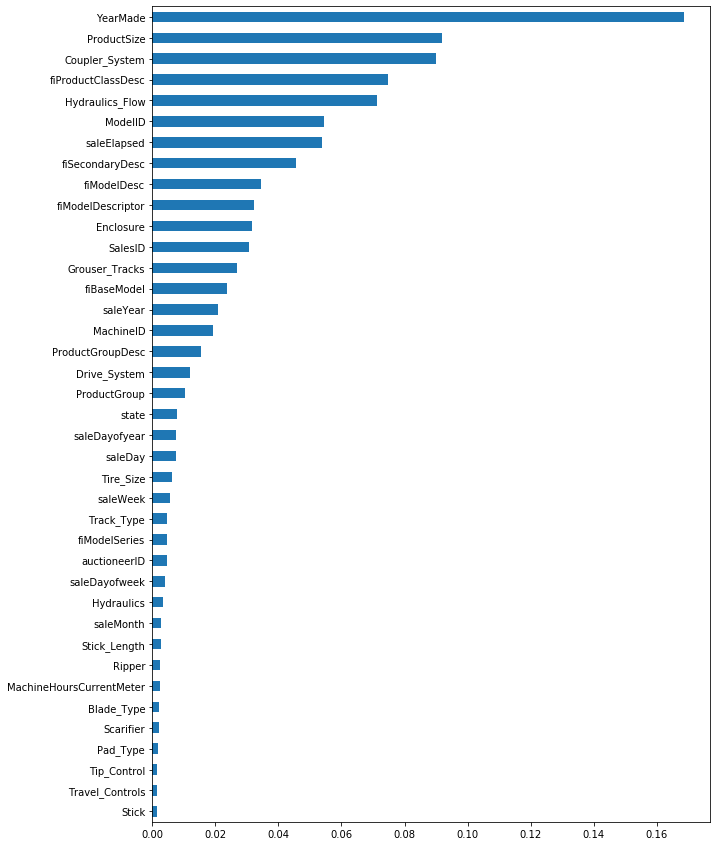

In [23]:
## plot feature importances
imp_series = pd.Series(m.feature_importances_, index=X_train.columns).sort_values()[25:]
imp_series.plot(kind='barh', figsize=(10,15), sort_columns=True)

In [24]:
## capturing only important features
imp_only_columns = imp_series.where(imp_series >= 0.005).dropna().index.to_list()
imp_only_columns

['saleWeek',
 'Tire_Size',
 'saleDay',
 'saleDayofyear',
 'state',
 'ProductGroup',
 'Drive_System',
 'ProductGroupDesc',
 'MachineID',
 'saleYear',
 'fiBaseModel',
 'Grouser_Tracks',
 'SalesID',
 'Enclosure',
 'fiModelDescriptor',
 'fiModelDesc',
 'fiSecondaryDesc',
 'saleElapsed',
 'ModelID',
 'Hydraulics_Flow',
 'fiProductClassDesc',
 'Coupler_System',
 'ProductSize',
 'YearMade']

In [25]:
X_train_imp_cols = X_train[imp_only_columns]

#### retrain the model on important features only

In [26]:
## retraining the model with only important columns
m1 = RandomForestRegressor(n_jobs=-1, n_estimators=30, max_features=0.5)
m1.fit(X_train_imp_cols, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [27]:
# score
m1.score(X_test[imp_only_columns], y_test)

0.8833457493475969

In [28]:
# get the RMLSE
mean_squared_error(y_test, m1.predict(X_test[imp_only_columns]), squared=False)

0.2442141068303283